Preprocessing: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.259.3762&rep=rep1&type=pdf

In [1]:
# All the libraries used
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from skimage import measure
from sklearn import metrics

import time
import random
import math

from scipy.ndimage import imread # Need to use scipy 1.1.0 to run imread
import scipy.ndimage
from scipy.misc import imresize
import scipy 
import seaborn as sns

/Users/haley/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Dataset 1

In [2]:
path1 = "/Users/haley/Desktop/CMPE 255/Rentinal Classification/gaussian_diabetic_retino/gaussian_filtered_images/gaussian_filtered_images/"
level = ["Mild","Moderate","No_DR","Proliferate_DR","Severe"]
file_id = []
gauss_x = []
for i in level:    
    for dirName, subdirList, fileList in os.walk(path1+i):
        # Randomly pick k images from each level
        random_images = random.choices(fileList,k=190)
        for filename in random_images: 
            file_id.append(filename)
            gauss_x.append(os.path.join(dirName,filename))   

In [3]:
target1 = pd.read_csv("gaussian_diabetic_retino/train.csv")
target1.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
target1['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [5]:
# To get the target values corresponding to given target csv file
gauss_y = []
for i in range(len(file_id)):
    code = file_id[i][:-4] # Slice to get rid of .png at the end of str
    label = target1['diagnosis'][target1['id_code'] == code]
    gauss_y.append(int(label))
gauss_y = np.array(gauss_y)

In [6]:
len(gauss_y)

950

## Dataset 2

In [7]:
path2 = "resized_diabetic_2015/resized_train_cropped/resized_train_cropped"  
target2 = pd.read_csv("resized_diabetic_2015/trainLabels_cropped.csv")
target2.sample(10)

,Unnamed: 0,Unnamed: 0.1,image,level
7252,7252,7256,9115_left,0
12971,12971,12980,16318_left,0
15509,15509,15519,19447_right,0
15687,15687,15697,19649_right,0
24531,24531,24545,31014_right,0
788,788,789,968_right,0
24214,24214,24228,30615_left,0
23789,23789,23803,30068_right,0
15317,15317,15327,19183_right,0
24850,24850,24864,31447_left,0


In [8]:
level_0 = target2["image"][target2['level'] == 0].tolist()
level_1 = target2["image"][target2['level'] == 1].tolist()
level_2 = target2["image"][target2['level'] == 2].tolist()
level_3 = target2["image"][target2['level'] == 3].tolist()
level_4 = target2["image"][target2['level'] == 4].tolist()

K = 708
level_0 = random.choices(level_0,k=K)
level_1 = random.choices(level_1,k=K)
level_2 = random.choices(level_2,k=K)
level_3 = random.choices(level_3,k=K)
level_4 = random.choices(level_4,k=K)

In [9]:
# Creating X and Y 
r_x = np.concatenate((level_0,level_1,level_2,level_3,level_4))
resized_y = np.concatenate((np.zeros(K),np.ones(K),np.ones(K)*2,np.ones(K)*3,np.ones(K)*4))

In [10]:
resized_x = []
for i in range(len(r_x)):
    img_path = path2+"/"+r_x[i]+".jpeg"
    resized_x.append(img_path)

# Data Preprocessing

In [11]:
pixels = 64

In [12]:
# 0. Read the data1 into Numpy
n1 = len(gauss_x)
one = np.zeros((n1,pixels,pixels))

# 0.5 Transfer All of the Data into array
for file_index in range(n1):
    one[file_index,:,:]   = cv2.resize(cv2.imread(gauss_x[file_index],0),(pixels,pixels))

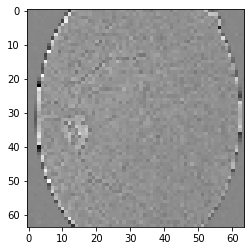

In [13]:
plt.imshow(one[0], cmap = plt.cm.gray)

In [14]:
# 0. Read the data2 into Numpy
n2 = len(resized_x)
two = np.zeros((n2,pixels,pixels))

for file_index in range(n2):
    #image_path = path2+"/"+resized_x[file_name]+".jpeg"
    two[file_index,:,:]   = cv2.resize(cv2.imread(resized_x[file_index],0),(pixels,pixels))

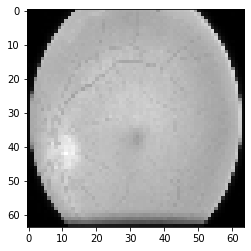

In [15]:
plt.imshow(two[0], cmap = plt.cm.gray)

In [16]:
cv2.imread(gauss_x[0]).shape

(224, 224, 3)

In [17]:
# Combination of the two dataset
Y = np.concatenate((gauss_y,resized_y))
whole = np.concatenate((one,two))

In [18]:
whole.shape

(4490, 64, 64)

In [19]:
n = whole.shape[0]

### Gaussian filter with Laplacian

* Read about how Laplacian of Gaussian works here: https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm
* Using cv2 to apply this technique: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

## Reshaping and splitting dataset

In [20]:
# LoG (Smooth) Function
data_array = []

for x in range(len(whole)):
    s = 1.75
    temp = scipy.ndimage.filters.gaussian_filter(
        whole[x,:,:],
        sigma = s
        )## Reshaping and splitting dataset
    lap_kernel = np.array([
        [0,1,0],
        [1,-4,1],
        [0,1,0]
    ])
    result = cv2.filter2D(temp,-1,lap_kernel)
    data_array.append(result)

In [21]:
# Add normalization
data_array = np.array(data_array)
data_array = (data_array - np.mean(data_array)) / math.sqrt(np.var(data_array))

In [22]:
data_array = data_array.flatten().reshape(n,-1)

In [23]:
data_array.shape

(4490, 4096)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data_array,Y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(3143, 4096), (3143,)
Test data and target sizes: 
(1347, 4096), (1347,)


### Histogram

* Applying Histograms Equalization: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
* In-depth lecture on histogram analysis of digital image: https://web.cs.wpi.edu/~emmanuel/courses/cs545/S14/slides/lecture02.pdf

In [25]:
hist_data1 = []
for i in gauss_x:
    img = cv2.resize(cv2.imread(i,0),(pixels,pixels))
    equ = cv2.equalizeHist(img)
    hist_data1.append(equ)
    
hist_data2 = []
for i in resized_x:
    img = cv2.resize(cv2.imread(i,0),(pixels,pixels))
    equ = cv2.equalizeHist(img)
    hist_data2.append(equ)
    
hist_data = np.concatenate([hist_data1,hist_data2])
hist_data = hist_data.flatten().reshape(n,-1)

In [26]:
#norm 
hist_data = (hist_data - np.mean(hist_data)) / math.sqrt(np.var(hist_data))

In [27]:
hist_data.shape # 224 pixels for each image

(4490, 4096)

In [28]:
# Using Histogram Equalization set
X_train, X_test, y_train, y_test = train_test_split(hist_data,Y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(3143, 4096), (3143,)
Test data and target sizes: 
(1347, 4096), (1347,)


### Median Filter
* Quick Tutorial: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

In [51]:
median_data1 = []
for i in gauss_x:
    img = cv2.resize(cv2.imread(i,0),(pixels,pixels))
    equ = cv2.medianBlur(img,5)
    median_data1.append(equ)
    
median_data2 = []
for i in resized_x:
    img = cv2.resize(cv2.imread(i,0),(pixels,pixels))
    equ = cv2.medianBlur(img,5)
    median_data2.append(equ)
    
median_data = np.concatenate([median_data1,median_data2])
median_data = median_data.flatten().reshape(n,-1)

In [52]:
# Add normalization
median_data = (median_data - np.mean(median_data)) / math.sqrt(np.var(median_data))

In [53]:
# Using Histogram Equalization set
X_train, X_test, y_train, y_test = train_test_split(median_data,Y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(3143, 50176), (3143,)
Test data and target sizes: 
(1347, 50176), (1347,)


## Histogram to Median Blur

In [60]:
comboHM_data1 = []
for i in gauss_x:
    img = cv2.resize(cv2.imread(i,0),(pixels,pixels))
    equ = cv2.equalizeHist(img)
    med = cv2.medianBlur(equ,5)
    comboHM_data1.append(med)
    
comboHM_data2 = []
for i in resized_x:
    img = cv2.resize(cv2.imread(i,0),(pixels,pixels))
    equ = cv2.equalizeHist(img)
    med = cv2.medianBlur(equ,5)
    comboHM_data2.append(med)
    
comboHM_data = np.concatenate([comboHM_data1,comboHM_data2])
comboHM_data = comboHM_data.flatten().reshape(n,-1)

In [61]:
# Add normalization
comboHM_data = (comboHM_data - np.mean(comboHM_data)) / math.sqrt(np.var(comboHM_data))

In [62]:
# Using Histogram Equalization set
X_train, X_test, y_train, y_test = train_test_split(comboHM_data,Y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(3143, 50176), (3143,)
Test data and target sizes: 
(1347, 50176), (1347,)


## MSE Calculation Comparison Between Filters
* https://towardsdatascience.com/image-classification-using-ssim-34e549ec6e12

In [73]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def psnr(imageA, imageB):
    mean_square = mse(imageA,imageB)
    if mean_square == 0:
        return 100
    max_pixels = 224 # all images are of length(pixels) of 224
    return 10*math.log10(max_pixels/mean_square)

def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    p = psnr(imageA,imageB)
    s = measure.compare_ssim(imageA, imageB)
    
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.3f, PSNR: %.3f, SSIM: %.3f" % (m, p, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
    # show the images
    plt.show()

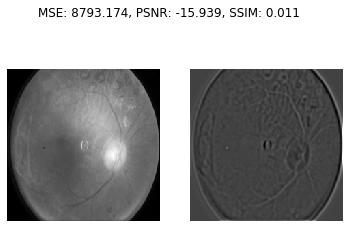

In [74]:
compare_images(whole[-1], result, "Regular vs. Laplacian of Gaussian")

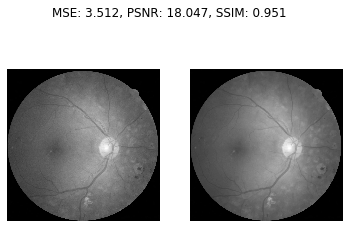

In [78]:
img = cv2.imread(resized_x[-1],0)
med = cv2.medianBlur(img,5)
compare_images(img, med, "Regular vs. Median Filter")

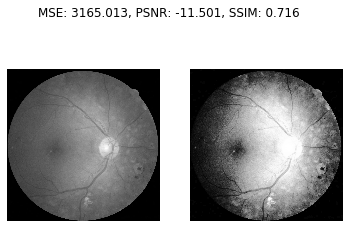

In [79]:
img = cv2.imread(resized_x[-1],0)
equ = cv2.equalizeHist(img)
compare_images(img, equ, "Regular vs. Histogram Equalization")

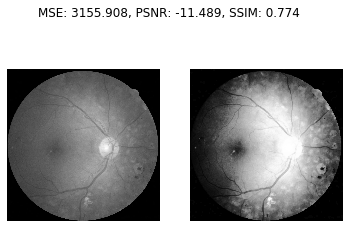

In [80]:
img = cv2.imread(resized_x[-1],0)
equ = cv2.equalizeHist(img)
med = cv2.medianBlur(equ,5)
compare_images(img, med, "Regular vs. Histogram Equalization->Median Blur")

## Reshaping and splitting dataset

In [ ]:
# Add normalization
data_array = np.array(data_array)
data_array = (data_array - np.mean(data_array)) / math.sqrt(np.var(data_array))

In [ ]:
data_array = data_array.flatten().reshape(n,-1)

In [ ]:
data_array.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_array,Y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

## Dimension Reduction, Training and Testing

**PCA**

In [25]:
# Preprocessing with PCA
reduced_pca = PCA(n_components=0.8)
reduced_pca.fit(X_train)
X_train_reduced = reduced_pca.transform(X_train)
X_test_reduced = reduced_pca.transform(X_test)
print("Reduced Shape:", X_train_reduced.shape)

Reduced Shape: (3143, 8)


w/ SVM

In [26]:
pca_svm = svm.SVC(kernel='rbf',C=2,decision_function_shape='ovo',gamma='auto')
starting_time = time.process_time()
pca_svm.fit(X_train_reduced,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", pca_svm.score(X_test_reduced, y_test))

Data fitting takes 1.0453299999999786 seconds
Testing Accuracy 0.46993318485523383


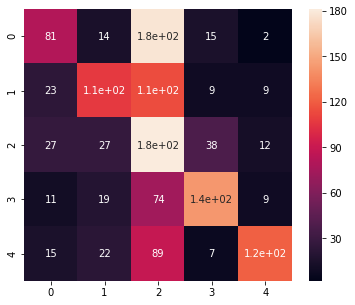

              precision    recall  f1-score   support

         0.0       0.52      0.28      0.36       290
         1.0       0.57      0.41      0.47       262
         2.0       0.28      0.64      0.39       285
         3.0       0.67      0.56      0.61       256
         4.0       0.79      0.48      0.59       254

    accuracy                           0.47      1347
   macro avg       0.57      0.47      0.49      1347
weighted avg       0.56      0.47      0.48      1347



In [27]:
y_pred = pca_svm.predict(X_test_reduced)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))

w/ KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier

pca_knn = KNeighborsClassifier(n_neighbors=13,weights='distance',algorithm='kd_tree')
starting_time = time.process_time()
pca_knn.fit(X_train_reduced,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", pca_knn.score(X_test_reduced, y_test))

Data fitting takes 0.005201999999997042 seconds
Testing Accuracy 0.46770601336302897


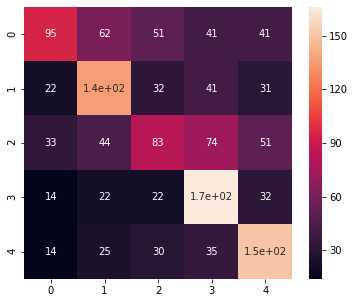

              precision    recall  f1-score   support

         0.0       0.53      0.33      0.41       290
         1.0       0.47      0.52      0.49       262
         2.0       0.38      0.29      0.33       285
         3.0       0.46      0.65      0.54       256
         4.0       0.49      0.59      0.54       254

    accuracy                           0.47      1347
   macro avg       0.47      0.48      0.46      1347
weighted avg       0.47      0.47      0.46      1347



In [29]:
y_pred = pca_knn.predict(X_test_reduced)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))

w/ LG

In [30]:
from sklearn.linear_model import LogisticRegression
pca_lg = LogisticRegression(random_state=45,penalty='l2')
starting_time = time.process_time()
pca_lg.fit(X_train_reduced,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", pca_lg.score(X_test_reduced, y_test))

Data fitting takes 0.08414200000001415 seconds
Testing Accuracy 0.2553823311061618


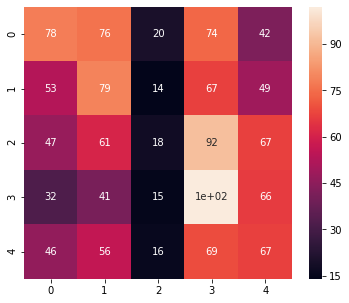

              precision    recall  f1-score   support

         0.0       0.30      0.27      0.29       290
         1.0       0.25      0.30      0.27       262
         2.0       0.22      0.06      0.10       285
         3.0       0.25      0.40      0.31       256
         4.0       0.23      0.26      0.25       254

    accuracy                           0.26      1347
   macro avg       0.25      0.26      0.24      1347
weighted avg       0.25      0.26      0.24      1347



In [31]:
y_pred = pca_lg.predict(X_test_reduced)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))

**KMeans**

In [32]:
# Preprocessing with KMeans
k = int(math.sqrt(X_train.shape[0]/2)) # Rule of thumb for picking K
starting_time = time.process_time()
kmnist_kmeans = KMeans(n_clusters=k, max_iter = 1000).fit(X_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
X_train_cluster = kmnist_kmeans.transform(X_train)
X_test_cluster = kmnist_kmeans.transform(X_test)
print("Reduced Shape:", X_train_cluster.shape)

Data fitting takes 79.42726399999998 seconds
Reduced Shape: (3143, 39)


w/ SVM

In [34]:
kmean_svm = svm.SVC(kernel='rbf',C=2,decision_function_shape='ovo',gamma='auto')
starting_time = time.process_time()
kmean_svm.fit(X_train_cluster,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", kmean_svm.score(X_test_cluster, y_test))

Data fitting takes 1.9449319999999943 seconds
Testing Accuracy 0.45657015590200445


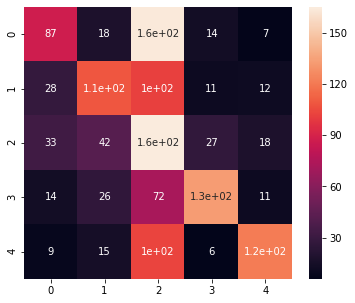

              precision    recall  f1-score   support

         0.0       0.51      0.30      0.38       290
         1.0       0.52      0.42      0.46       262
         2.0       0.27      0.58      0.37       285
         3.0       0.70      0.52      0.60       256
         4.0       0.72      0.48      0.57       254

    accuracy                           0.46      1347
   macro avg       0.54      0.46      0.48      1347
weighted avg       0.54      0.46      0.47      1347



In [35]:
y_pred = kmean_svm.predict(X_test_cluster)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))

w/ KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

kmean_knn = KNeighborsClassifier(n_neighbors=13,weights='distance',algorithm='kd_tree')
starting_time = time.process_time()
kmean_knn.fit(X_train_cluster,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", kmean_knn.score(X_test_cluster, y_test))

Data fitting takes 0.012594000000035521 seconds
Testing Accuracy 0.46770601336302897


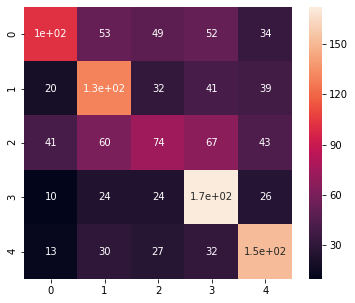

              precision    recall  f1-score   support

         0.0       0.55      0.35      0.43       290
         1.0       0.44      0.50      0.47       262
         2.0       0.36      0.26      0.30       285
         3.0       0.47      0.67      0.55       256
         4.0       0.52      0.60      0.55       254

    accuracy                           0.47      1347
   macro avg       0.47      0.48      0.46      1347
weighted avg       0.47      0.47      0.46      1347



In [37]:
y_pred = kmean_knn.predict(X_test_cluster)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))

w/ LG

In [38]:
from sklearn.linear_model import LogisticRegression
kmean_lg = LogisticRegression(random_state=45,penalty='l2')
starting_time = time.process_time()
kmean_lg.fit(X_train_cluster,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", kmean_lg.score(X_test_cluster, y_test))

Data fitting takes 0.9723179999999729 seconds
Testing Accuracy 0.2635486265775798


/Users/haley/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


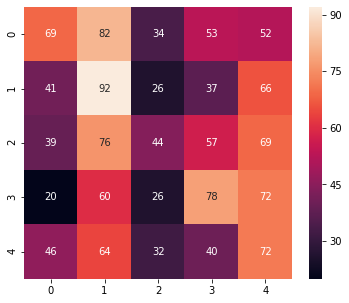

              precision    recall  f1-score   support

         0.0       0.32      0.24      0.27       290
         1.0       0.25      0.35      0.29       262
         2.0       0.27      0.15      0.20       285
         3.0       0.29      0.30      0.30       256
         4.0       0.22      0.28      0.25       254

    accuracy                           0.26      1347
   macro avg       0.27      0.27      0.26      1347
weighted avg       0.27      0.26      0.26      1347



In [39]:
y_pred = kmean_lg.predict(X_test_cluster)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))